In [1]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [154]:
# create a KAN: 5D inputs, 0 output hidden neurons, 1 multiplication hidden neuron, 1D output. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2, [0, 1]], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [155]:
 # create dataset f(x,y) = x^n * exp(alpha*x)
def create_stable_function(alpha=5):
    def f(x):
        # Ensure x[:,[0]] is positive for fractional power
        x1 = torch.abs(x[:,[0]]) + 1e-6  # Add small epsilon to avoid 0
        
        # Use log-space for the power operation
        power_term = torch.exp(2 * torch.log(x1))
        
        # Clip the exponential term to avoid overflow
        exp_term = torch.clip(torch.pi * x[:,[1]], -alpha, alpha)
        exp_term = torch.exp(exp_term)
        
        return power_term * exp_term
    return f

# Use the stable version
dataset = create_dataset(create_stable_function(alpha=5), n_var=2)

# create dataset g(x,y) = sin(x)^2 * cos(x)
# g = lambda x: torch.sin(x[:,[0]])**2 * torch.cos(x[:,[1]])

In [156]:
print(dataset)

{'train_input': tensor([[-0.0075,  0.5547],
        [ 0.5364,  0.1791],
        [-0.8230,  0.1526],
        ...,
        [-0.3216, -0.4567],
        [ 0.0036, -0.3966],
        [-0.1923, -0.8376]]), 'test_input': tensor([[-0.0850, -0.2418],
        [-0.7799, -0.0967],
        [-0.0061, -0.4609],
        ...,
        [ 0.0392, -0.2945],
        [-0.3037, -0.0922],
        [ 0.7534,  0.8848]]), 'train_label': tensor([[3.2028e-04],
        [5.0520e-01],
        [1.0941e+00],
        [2.7491e+00],
        [1.0502e+00],
        [1.9820e-02],
        [2.7827e-04],
        [2.4970e+00],
        [1.7185e-03],
        [1.3212e+00],
        [1.0618e-02],
        [1.6467e-01],
        [9.5560e-02],
        [1.2027e+00],
        [1.5248e+00],
        [2.0041e-03],
        [1.1407e-01],
        [2.6544e+00],
        [4.8162e-02],
        [2.2772e-02],
        [9.0674e-03],
        [9.9706e-02],
        [4.5952e-02],
        [1.3474e-01],
        [5.2313e-02],
        [1.2449e-02],
        [1.1201e+

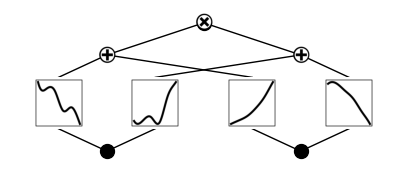

In [157]:
dataset['train_input'].shape, dataset['train_label'].shape


model(dataset['train_input'])
model.plot(beta=100)

In [158]:
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

| train_loss: 2.73e-01 | test_loss: 2.42e-01 | reg: 1.19e+01 | : 100%|█| 20/20 [00:00<00:00, 29.03it

saving model version 0.1


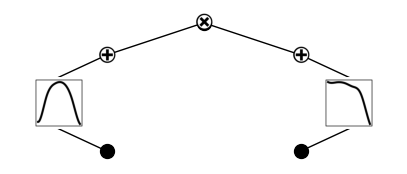

In [159]:
model.plot()

saving model version 0.2


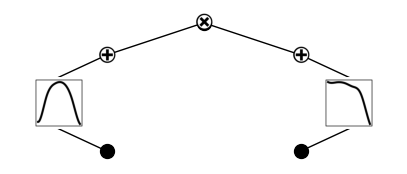

In [160]:
model.prune()
model.plot()

saving model version 0.2


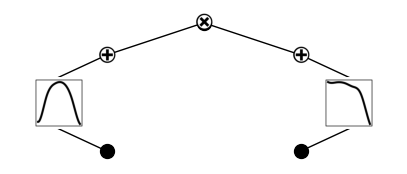

In [161]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [162]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 3.72e-03 | test_loss: 4.34e-03 | reg: 6.08e+00 | : 100%|█| 50/50 [00:01<00:00, 38.93it


saving model version 0.3


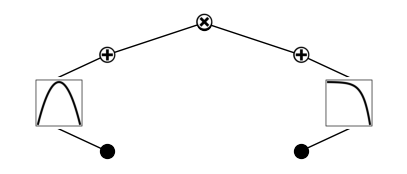

In [163]:
model.plot()

In [164]:
mode =  'auto'

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=1.0000001192092896, c=2
fixing (0,0,1) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with exp, r2=0.9999972581863403, c=2
saving model version 0.4


In [165]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 8.43e-07 | test_loss: 1.07e-06 | reg: 0.00e+00 | : 100%|█| 50/50 [00:00<00:00, 67.29it

saving model version 0.5


In [166]:
model.symbolic_formula()[0][0]

1.0*(4.29281499236822e-9 - 0.125098049642509*exp(3.14159250259399*x_2))*(-7.99374558795466*(-x_1 - 2.84224655090341e-8)**2 - 3.33791103912517e-6)

In [167]:
sf = model.symbolic_formula()[0][0]
nsimplify(ex_round(ex_round(sf, 2),3))

519*x_1**2*exp(493*x_2/157)/500